In [1]:
from line_solver import *
import numpy as np
GlobalConstants.set_verbose(VerboseLevel.STD)

In [2]:
model = Network('model')

# Create 5 multi-server queues with PS scheduling
node = np.empty(5, dtype=object)
node[0] = Queue(model, 'Queue1', SchedStrategy.PS)
node[0].set_number_of_servers(1)
node[1] = Queue(model, 'Queue2', SchedStrategy.PS)
node[1].set_number_of_servers(2)
node[2] = Queue(model, 'Queue3', SchedStrategy.PS)
node[2].set_number_of_servers(3)
node[3] = Queue(model, 'Queue4', SchedStrategy.PS)  # only closed classes
node[3].set_number_of_servers(4)
node[4] = Queue(model, 'Queue5', SchedStrategy.PS)  # only open classes
node[4].set_number_of_servers(5)

source = Source(model, 'Source')
sink = Sink(model, 'Sink')

# Create job classes
jobclass = np.empty(2, dtype=object)
jobclass[0] = ClosedClass(model, 'ClosedClass', 3, node[0], 0)
jobclass[1] = OpenClass(model, 'OpenClass', 0)

# Set service rates
for i in range(5):
    node[i].set_service(jobclass[0], Exp(i+1))
    node[i].set_service(jobclass[1], Exp(np.sqrt(i+1)))

# Set arrival rate for open class
source.set_arrival(jobclass[1], Exp(0.3))

In [3]:
# Setup routing matrix
M = model.get_number_of_stations()
K = model.get_number_of_classes()

P = model.init_routing_matrix()

# Closed class routing: Queue1 -> Queue2 -> Queue3 -> Queue4 -> Queue1 (circular)
P.set(jobclass[0], jobclass[0], node[0], node[1], 1.0)
P.set(jobclass[0], jobclass[0], node[1], node[2], 1.0)
P.set(jobclass[0], jobclass[0], node[2], node[3], 1.0)
P.set(jobclass[0], jobclass[0], node[3], node[0], 1.0)

# Open class routing: Source -> Queue1 -> Queue2 -> Queue3 -> Queue5 -> Sink
P.set(jobclass[1], jobclass[1], source, node[0], 1.0)
P.set(jobclass[1], jobclass[1], node[0], node[1], 1.0)
P.set(jobclass[1], jobclass[1], node[1], node[2], 1.0)
P.set(jobclass[1], jobclass[1], node[2], node[4], 1.0)
P.set(jobclass[1], jobclass[1], node[4], sink, 1.0)

model.link(P)

In [4]:
print('This example shows the execution of the solver on a 2-class mixed model with 5 multi-server nodes.')# Create solverssolver = np.array([], dtype=object)solver = np.append(solver, SolverCTMC(model, cutoff=3))  # CTMC is infinite on this modelsolver = np.append(solver, SolverJMT(model, samples=100000, seed=23000))solver = np.append(solver, SolverMVA(model, method='exact'))solver = np.append(solver, SolverMAM(model, seed=23000, keep=False, verbose=True))# Solve and display resultsAvgTable = np.empty(len(solver), dtype=object)for s in range(len(solver)):    print(f'\nSOLVER: {solver[s].get_name()}')    AvgTable[s] = solver[s].get_avg_table()

This example shows the execution of the solver on a 2-class mixed model with 5 multi-server nodes.

SOLVER: SolverCTMC
CTMC analysis [method: default, lang: java, env: 21.0.8] completed in 3.186061s.
   Station     JobClass    QLen    Util   RespT  ResidT    ArvR    Tput
0   Queue1  ClosedClass  2.1993  0.7206  3.0519  3.0519  0.7206  0.7206
1   Queue1    OpenClass  0.9534  0.2475  3.8526  3.8526  0.2475  0.2475
2   Queue2  ClosedClass  0.3800  0.1802  0.5273  0.5273  0.7206  0.7206
3   Queue2    OpenClass  0.1865  0.0875  0.7536  0.7536  0.2475  0.2475
4   Queue3  ClosedClass  0.2406  0.0801  0.3338  0.3338  0.7206  0.7206
5   Queue3    OpenClass  0.1432  0.0476  0.5785  0.5785  0.2475  0.2475
6   Queue4  ClosedClass  0.1802  0.0450  0.2500  0.2500  0.7206  0.7206
9   Queue5    OpenClass  0.1107  0.0221  0.4472  0.4472  0.2475  0.2475
11  Source    OpenClass  0.0000  0.0000  0.0000  0.0000  0.0000  0.2475

SOLVER: SolverJMT
JMT Model: /tmp/workspace/jsim/11563255541065660629/jmodel.js

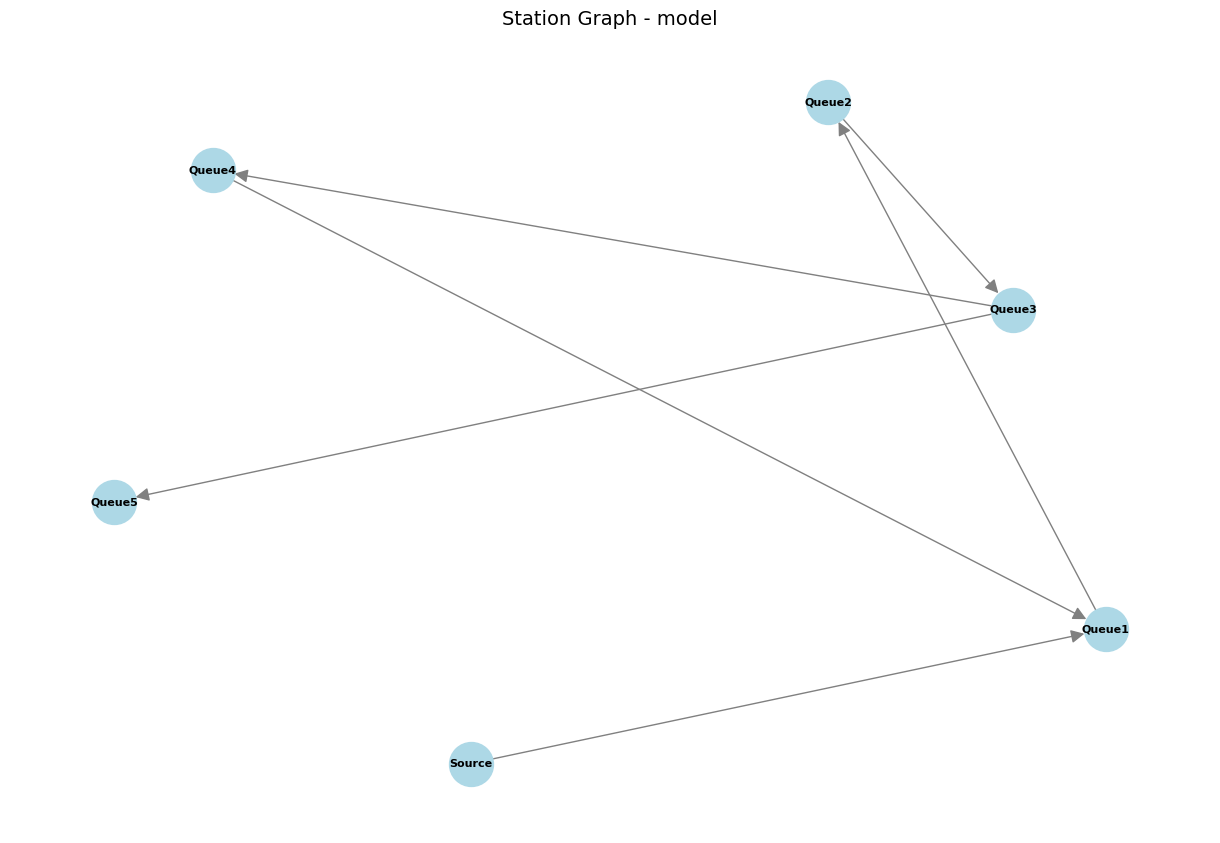

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [5]:
model.plot()